In [1]:
import sys
import scipy.io
import numpy as np
sys.path.append('../src')
import pandas as pd
import matplotlib.pyplot as plt
from mvt_brr import MVTModel
import scipy.optimize as opt
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib
matplotlib.rc('xtick', labelsize=15)
matplotlib.rc('ytick', labelsize=15)

In [2]:
data = scipy.io.loadmat('../leheron_trialbytrial/leheron_blockSwitchIndex.mat')
block_order_df = pd.read_csv('../leheron_trialbytrial/leheron_blockOrder.csv')
df_trials = pd.read_csv("../leheron_trialbytrial/leheron_trialbytrial.csv")

In [3]:
block_switch_index = data['blockSwitchIndex']
n_subjects = block_switch_index.shape[1]

In [4]:
block_order_df.iloc[0,]

1    1
2    2
Name: 0, dtype: int64

23 July

In [4]:
df_trials.head(5)

,sub,patch,env,leaveT,meanLT,dmLeave
0,1,3,1,45.034784,40.532927,4.501856
1,1,2,1,44.403900,40.532927,3.870973
2,1,3,1,61.168672,40.532927,20.635745
3,1,1,1,26.803514,40.532927,-13.729413
4,1,3,1,56.992002,40.532927,16.459075


In [49]:
grouped_df = df_trials.groupby(['env', 'patch']).agg(
    mean_leaveT=('leaveT','mean'),
    sd_leaveT=('leaveT', 'std')
).reset_index()

print(grouped_df)

   env  patch  mean_leaveT  sd_leaveT
0    1      1    11.137706   6.020383
1    1      2    15.051354   6.435201
2    1      3    19.709716   7.450578
3    2      1    14.309812   6.639575
4    2      2    18.947625   7.008822
5    2      3    23.441306   7.471792


In [111]:
model = MVTModel(decay_type='exponential')
MVT_rich, MVT_poor = model.run()

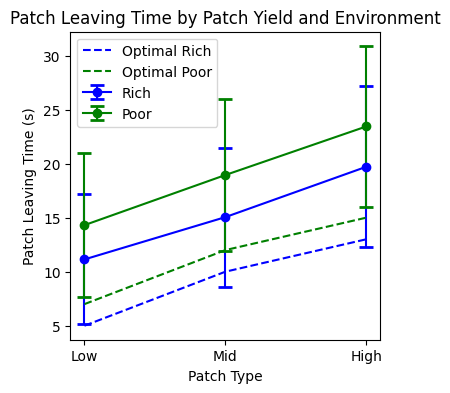

In [61]:
envs = grouped_df['env'].unique()

colors = {1: 'blue', 2: 'green'}
labels = {1: 'Rich', 2:'Poor'}

plt.figure(figsize=(4, 4))

for env in envs:
    env_data = grouped_df[grouped_df['env']==env]

    plt.errorbar(
        env_data['patch'],
        env_data['mean_leaveT'],
        yerr=env_data['sd_leaveT'],
        fmt='o-',
        capsize = 5,
        capthick = 2,
        color = colors[env],
        label = labels[env]
    )
plt.plot([1, 2, 3], MVT_rich, 'b--', label='Optimal Rich')
plt.plot([1, 2, 3], MVT_poor, 'g--', label='Optimal Poor')
plt.xticks([1, 2, 3], ['Low', "Mid", "High"])

plt.xlabel('Patch Type')
plt.ylabel('Patch Leaving Time (s)')
plt.title('Patch Leaving Time by Patch Yield and Environment')
plt.legend()
# plt.legend(title='Subjects')

plt.show()

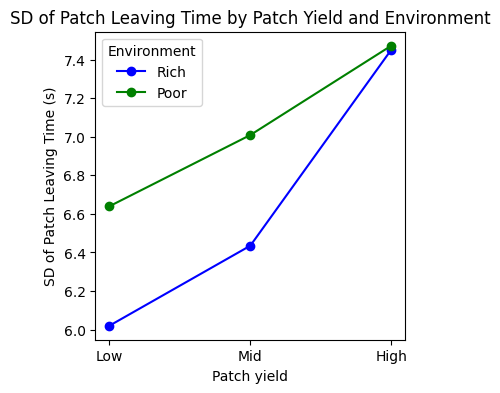

In [62]:
# Create a plot for each environment
plt.figure(figsize=(4, 4))

for env in envs:
    env_data = grouped_df[grouped_df['env'] == env]
    
    # Plot the variance data
    plt.plot(
        env_data['patch'], 
        env_data['sd_leaveT'], 
        'o-', 
        color=colors[env],
        label=labels[env]
    )

# Set the x-axis ticks and labels to ensure correct order
plt.xticks([1, 2, 3], ['Low', 'Mid', 'High'])

# Add labels and title
plt.xlabel('Patch yield')
plt.ylabel('SD of Patch Leaving Time (s)')
plt.title('SD of Patch Leaving Time by Patch Yield and Environment')
plt.legend(title='Environment')

# Show the plot
plt.show()

In [46]:
df_trials.head()

,sub,patch,env,leaveT,meanLT,dmLeave
3,1,1,1,26.803514,40.532927,-13.729413
6,1,1,1,43.309626,40.532927,2.776699
10,1,1,1,31.291389,40.532927,-9.241538
1,1,2,1,44.403900,40.532927,3.870973
5,1,2,1,46.472907,40.532927,5.939980


In [42]:
df_trials_agg = df_trials.groupby(['sub', 'env', 'patch']).agg(
    mean_leaveT=('leaveT','mean'),
    std_leaveT=('leaveT','std')
).reset_index()

In [43]:
df_trials_agg.head(10)

,sub,env,patch,mean_leaveT,std_leaveT
0,1,1,1,33.801510,8.534545
1,1,1,2,43.101277,4.178119
2,1,1,3,56.137283,6.334317
3,1,2,1,29.041616,3.982665
4,1,2,2,39.161016,5.100677
5,1,2,3,41.954861,2.279121
6,2,1,1,6.694433,2.144160
7,2,1,2,9.952141,2.321613
8,2,1,3,14.034431,2.769732
9,2,2,1,9.289800,1.355251


In [53]:
grouped_df = df_trials_agg.groupby(['env', 'patch']).agg(
    mean_leaveT=('mean_leaveT', 'mean'),
    sd_leaveT=('mean_leaveT', 'std'),
    n=('mean_leaveT', 'size')  # Count of observations
).reset_index()

print(grouped_df)

   env  patch  mean_leaveT  sd_leaveT   n
0    1      1    11.959238   5.707599  39
1    1      2    16.537479   6.417519  39
2    1      3    21.157310   7.851206  39
3    2      1    15.431288   5.702317  39
4    2      2    20.075754   6.258272  39
5    2      3    25.029085   6.645499  39


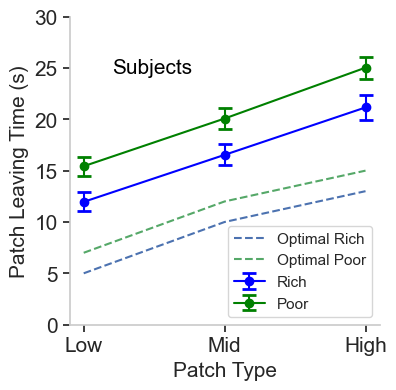

In [67]:
# Calculate SEM based on standard deviation and sample size (n)
grouped_df['sem_leaveT'] = grouped_df['sd_leaveT'] / np.sqrt(grouped_df['n'])

# Define the environments and their properties
envs = grouped_df['env'].unique()
colors = {1: 'blue', 2: 'green'}
labels = {1: 'Rich', 2: 'Poor'}

plt.figure(figsize=(4, 4))

# Plot the error bars using SEM
for env in envs:
    env_data = grouped_df[grouped_df['env'] == env]

    plt.errorbar(
        env_data['patch'],
        env_data['mean_leaveT'],
        yerr=env_data['sem_leaveT'],  # Use SEM instead of standard deviation
        fmt='o-',
        capsize=5,
        capthick=2,
        color=colors[env],
        label=labels[env]
    )

# Plot the optimal lines for rich and poor environments
plt.plot([1, 2, 3], MVT_rich, 'b--', label='Optimal Rich')
plt.plot([1, 2, 3], MVT_poor, 'g--', label='Optimal Poor')

# Customize the x-axis labels
plt.xticks([1, 2, 3], ['Low', "Mid", "High"])
plt.text(1.2, 25, 'Subjects', color='black', va='center', ha='left', fontsize=15)

# Set labels and title
plt.xlabel('Patch Type', fontsize = 15)
plt.ylabel('Patch Leaving Time (s)', fontsize = 15)
plt.ylim(0, 30)
# plt.title('Subjects')

# Show legend
plt.legend()
plt.grid(False)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.tick_params(axis='both', which='both', length=5)

plt.show()

In [57]:
grouped_df_sd = df_trials_agg.groupby(['env', 'patch']).agg(
    mean_leaveT=('std_leaveT', 'mean'),
    sd_leaveT=('std_leaveT', 'std'),
    n=('mean_leaveT', 'size')  # Count of observations
).reset_index()

print(grouped_df_sd)

   env  patch  mean_leaveT  sd_leaveT   n
0    1      1     3.362451   1.628552  39
1    1      2     3.442786   1.635803  39
2    1      3     3.918168   1.669319  39
3    2      1     3.873778   1.873209  39
4    2      2     3.481682   2.141932  39
5    2      3     4.138209   2.516998  39


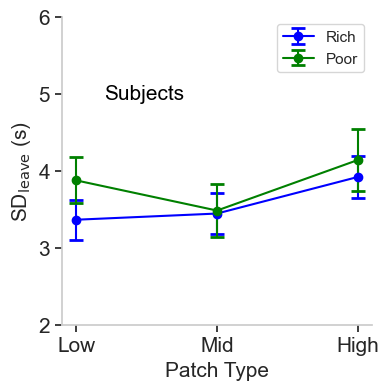

In [153]:
grouped_df_sd['sem_leaveT'] = grouped_df_sd['sd_leaveT'] / np.sqrt(grouped_df_sd['n'])

# Define the environments and their properties
envs = grouped_df_sd['env'].unique()
colors = {1: 'blue', 2: 'green'}
labels = {1: 'Rich', 2: 'Poor'}

plt.figure(figsize=(4, 4))

# Plot the error bars using SEM
for env in envs:
    env_data = grouped_df_sd[grouped_df_sd['env'] == env]

    plt.errorbar(
        env_data['patch'],
        env_data['mean_leaveT'],
        yerr=env_data['sem_leaveT'],  # Use SEM instead of SD
        fmt='o-',
        capsize=5,
        capthick=2,
        color=colors[env],
        label=labels[env]
    )

# Customize the x-axis labels
plt.xticks([1, 2, 3], ['Low', "Mid", "High"])

# Set labels and limits
plt.xlabel('Patch Type', fontsize = 15)
plt.ylabel(r'SD$_{\mathrm{leave}}$ (s)', fontsize = 15)
plt.ylim(2, 6)
plt.text(1.2, 5, 'Subjects', color='black', va='center', ha='left', fontsize=15)
# Show legend
plt.legend()

# Turn off the grid
plt.grid(False)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.tick_params(axis='both', which='both', length=5)

# Display the plot
plt.show()

In [15]:
mean_leave_by_env = df_trials_agg.groupby(['sub', 'env'])['mean_leaveT'].mean().unstack()

# Find subjects where mean leave time in env 1 is higher than in env 2
subjects_higher_in_env1 = mean_leave_by_env[mean_leave_by_env[1] > mean_leave_by_env[2]].index.tolist()

# Display the results
print("Subjects with higher mean leave time in environment 1 than in environment 2:")
print(subjects_higher_in_env1)

Subjects with higher mean leave time in environment 1 than in environment 2:
[1, 7, 18, 21]


/var/folders/fp/j9ldfbxj2_gflf_hz4bf_wyc0000gn/T/ipykernel_67711/2249423077.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sd_leave_df = df_trials.groupby(['sub', 'env']).apply(calculate_sd_leave).reset_index()
/var/folders/fp/j9ldfbxj2_gflf_hz4bf_wyc0000gn/T/ipykernel_67711/2249423077.py:66: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k+" (-> color='k'). The keyword argument will take precedence.
  ax.errorbar(x_positions, means, yerr=errors, fmt='k+', color='brown', markersize=12, capsize=7, elinewidth=3, capthick=1)


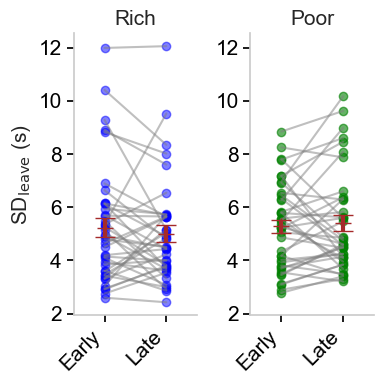

In [95]:
# Calculate early and late SD_leave per subject per environment
def calculate_sd_leave(group):
    n = len(group)
    early_cutoff = n // 2  # 50th percentile for a 50/50 split based on trial count
    
    # Select early and late trials
    early_trials = group.iloc[:early_cutoff]  # First half of the trials
    late_trials = group.iloc[early_cutoff:]   # Second half of the trials
    
    # Calculate standard deviation for early and late trials
    early_sd = early_trials['leaveT'].std()
    late_sd = late_trials['leaveT'].std()
    
    return pd.Series({'early_sd': early_sd, 'late_sd': late_sd})

# Apply the calculation per subject and environment
sd_leave_df = df_trials.groupby(['sub', 'env']).apply(calculate_sd_leave).reset_index()

# Plot settings
fig, axes = plt.subplots(1, 2, figsize=(4, 4), sharey=True)

for ax in axes:
    ax.grid(False)  # Turn off grid lines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.tick_params(axis='both', which='both', length=5, colors='black', direction='out')
    
# Adjust x-ticks and labels to be closely spaced
x_positions = [0.85, 1.15]  # Positions for "Early" and "Late"

# Rich environment plot
rich_df = sd_leave_df[sd_leave_df['env'] == 1]
axes[0].scatter([x_positions[0]] * len(rich_df), rich_df['early_sd'], color='blue', alpha=0.5)
axes[0].scatter([x_positions[1]] * len(rich_df), rich_df['late_sd'], color='blue', alpha=0.5)

# Connecting lines for rich environment
for _, row in rich_df.iterrows():
    axes[0].plot(x_positions, [row['early_sd'], row['late_sd']], color='gray', alpha=0.5)

axes[0].set_title('Rich', fontsize=15)
axes[0].set_xticks(x_positions)
axes[0].set_xticklabels(['Early', 'Late'], rotation=45, ha='right', fontsize=15)
axes[0].set_ylabel(r'SD$_{\mathrm{leave}}$ (s)', fontsize=15)
axes[0].set_xlim(0.7, 1.3)  # Adjust x-axis limits to reduce the gap

# Poor environment plot
poor_df = sd_leave_df[sd_leave_df['env'] == 2]
axes[1].scatter([x_positions[0]] * len(poor_df), poor_df['early_sd'], color='green', alpha=0.6)
axes[1].scatter([x_positions[1]] * len(poor_df), poor_df['late_sd'], color='green', alpha=0.6)

# Connecting lines for poor environment
for _, row in poor_df.iterrows():
    axes[1].plot(x_positions, [row['early_sd'], row['late_sd']], color='gray', alpha=0.5)

axes[1].set_title('Poor', fontsize=15)
axes[1].set_xticks(x_positions)
axes[1].set_xticklabels(['Early', 'Late'], rotation=45, ha='right', fontsize=15)
axes[1].set_xlim(0.7, 1.3)  # Adjust x-axis limits to reduce the gap

# Add means and standard error bars to both plots
for ax, env_df in zip(axes, [rich_df, poor_df]):
    means = [env_df['early_sd'].mean(), env_df['late_sd'].mean()]
    errors = [env_df['early_sd'].sem(), env_df['late_sd'].sem()]
    ax.errorbar(x_positions, means, yerr=errors, fmt='k+', color='brown', markersize=12, capsize=7, elinewidth=3, capthick=1)

plt.tight_layout()
plt.show()

In [98]:
patch_counts = df_trials.groupby(['sub', 'env'])['patch'].count().reset_index()
patch_counts.columns = ['sub', 'env', 'patch_count']
max_patch_count = patch_counts.loc[patch_counts.groupby('env')['patch_count'].idxmax()]

print(max_patch_count)

    sub  env  patch_count
20   11    1           41
9     5    2           39


In [101]:
patch_counts[patch_counts["sub"]==11]

,sub,env,patch_count
20,11,1,41
21,11,2,38


In [128]:
model = MVTModel(decay_type='exponential')
MVT_rich, MVT_poor = model.run()

In [129]:
MVT_poor, MVT_rich = MVT_poor-1, MVT_rich-1

In [130]:
MVT_rich = np.dot([0.2, 0.3, 0.5], MVT_rich)
MVT_poor = np.dot([0.5, 0.3, 0.2], MVT_poor)

In [131]:
MVT_poor, MVT_rich

(np.float64(9.1), np.float64(9.5))

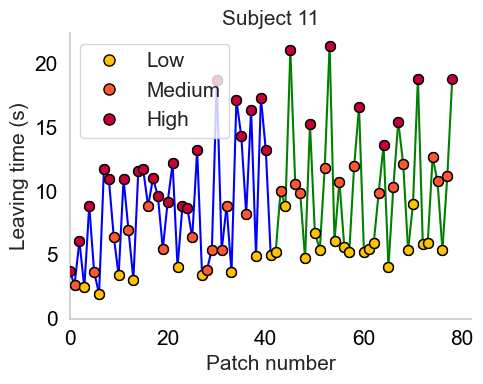

In [148]:
patch_colors = {1: '#FFC300', 2: '#FF5733', 3: '#C70039'}

subject_11_data = df_trials[df_trials['sub'] == 11].reset_index(drop=True)

plt.figure(figsize=(5, 4))

# Plotting the line segments and adding markers with the appropriate colors
for i in range(1, len(subject_11_data)):
    # Determine line color based on environment
    if subject_11_data.loc[i-1, 'env'] == 1:
        line_color = 'blue'
    elif subject_11_data.loc[i-1, 'env'] == 2:
        line_color = 'green'
    
    # Plot the line segment
    plt.plot([i-1, i], [subject_11_data.loc[i-1, 'leaveT'], subject_11_data.loc[i, 'leaveT']], color=line_color)
    
    # Add a marker at each point with the color representing the patch type
    plt.scatter(i-1, subject_11_data.loc[i-1, 'leaveT'], color=patch_colors[subject_11_data.loc[i-1, 'patch']], edgecolor='black', s=50, zorder=3)
    plt.scatter(i, subject_11_data.loc[i, 'leaveT'], color=patch_colors[subject_11_data.loc[i, 'patch']], edgecolor='black', s=50, zorder=3)

plt.xlabel('Patch number', fontsize=15)
plt.ylabel('Leaving time (s)', fontsize=15)
plt.title('Subject 11', fontsize=15)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_position(('outward', 0))
ax.spines['bottom'].set_position(('outward', 0))
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)

ax.tick_params(axis='both', which='both', length=5, width=1.5, labelsize=15, colors='black')
ax.grid(False)

from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#FFC300', markersize=8, label='Low', markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#FF5733', markersize=8, label='Medium', markeredgecolor='black'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#C70039', markersize=8, label='High', markeredgecolor='black')
]

ax.legend(handles=legend_elements, fontsize=15)

plt.tight_layout()
plt.show()

### Distribution of subjects' leaving times for a given patch type

In [85]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import scipy.stats as stats

In [33]:
df_scaled = df_trials.copy()

minmax_scaler = MinMaxScaler()
zscore_scaler = StandardScaler()
robust_scaler = RobustScaler()

for subject in df_trials['sub'].unique():
    subject_mask = df_trials['sub'] == subject

    leave_times = df_trials.loc[subject_mask, 'leaveT'].values.reshape(-1, 1)

    df_scaled.loc[subject_mask, 'leaveT_minmax'] = minmax_scaler.fit_transform(leave_times).ravel()
    df_scaled.loc[subject_mask, 'leaveT_zscore'] = zscore_scaler.fit_transform(leave_times).ravel()
    df_scaled.loc[subject_mask, 'leaveT_robust'] = robust_scaler.fit_transform(leave_times).ravel()

df_scaled.head()

,sub,patch,env,leaveT,meanLT,dmLeave,leaveT_minmax,leaveT_zscore,leaveT_robust
0,1,3,1,45.034784,40.532927,4.501856,0.546632,0.423478,0.396917
1,1,2,1,44.403900,40.532927,3.870973,0.529860,0.365044,0.347510
2,1,3,1,61.168672,40.532927,20.635745,0.975551,1.917843,1.660421
3,1,1,1,26.803514,40.532927,-13.729413,0.061953,-1.265152,-1.030841
4,1,3,1,56.992002,40.532927,16.459075,0.864514,1.530989,1.333331


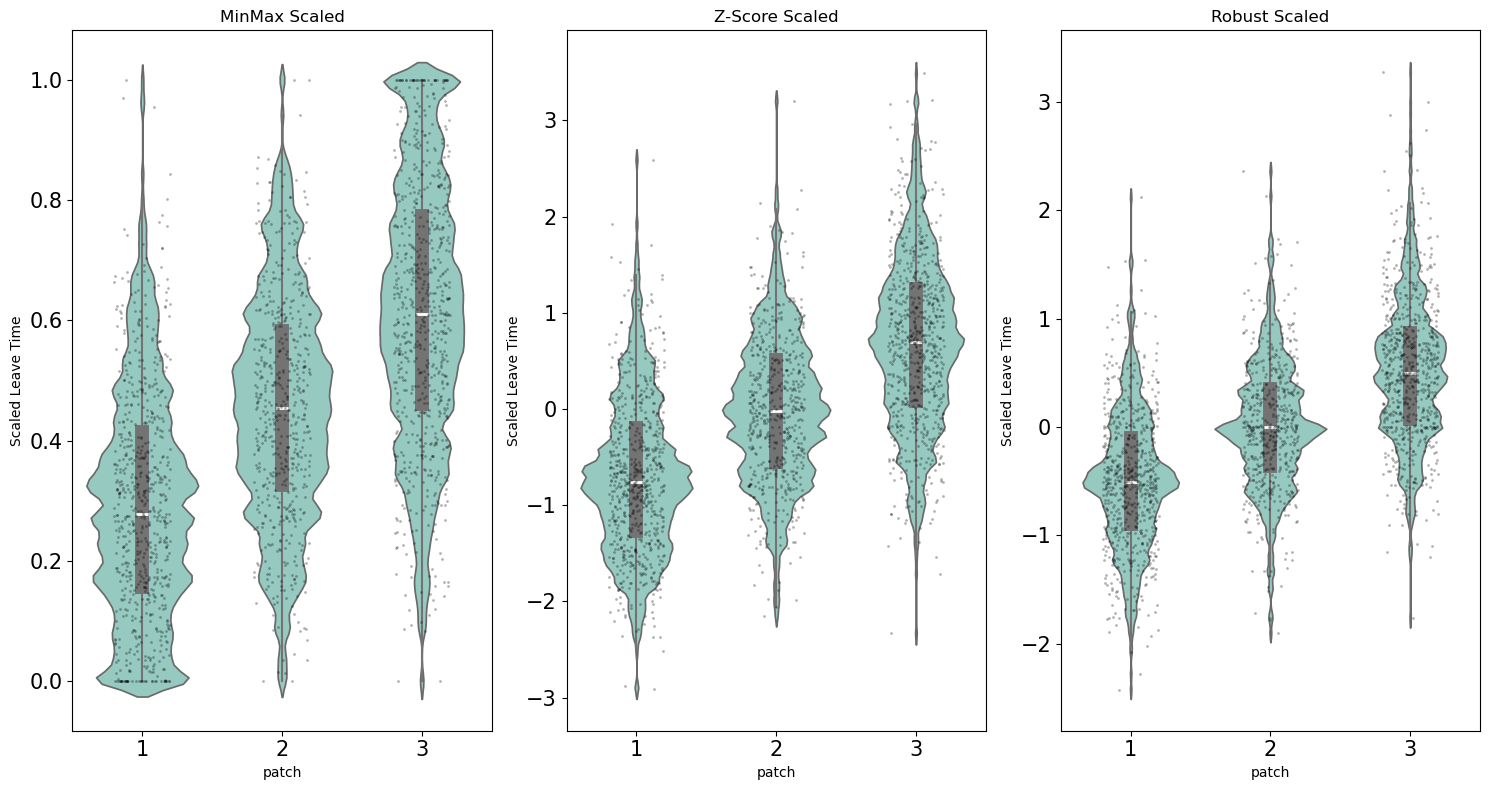

In [81]:
# Create subplots for each scaling method
fig, axes = plt.subplots(1, 3, figsize=(15, 8))

# Plot for each scaling method
scaling_methods = ['leaveT_minmax', 'leaveT_zscore', 'leaveT_robust']
titles = ['MinMax Scaled', 'Z-Score Scaled', 'Robust Scaled']

for ax, method, title in zip(axes, scaling_methods, titles):
    sns.violinplot(x='patch', y=method, data=df_scaled,
                    # bw_method='silverman',
                    bw_adjust=0.25,
                    inner='box', color="#8DD3C7", ax=ax, inner_kws=dict(box_width=10, whis_width=1.5, color=".45"))
    
    # Add individual points with jitter
    sns.stripplot(x='patch', y=method, data=df_scaled,
                 size=2, color='black', alpha=0.3,
                 jitter=0.2, ax=ax)
    
    ax.set_title(title)
    ax.set_ylabel('Scaled Leave Time')
    
plt.tight_layout()
plt.show()

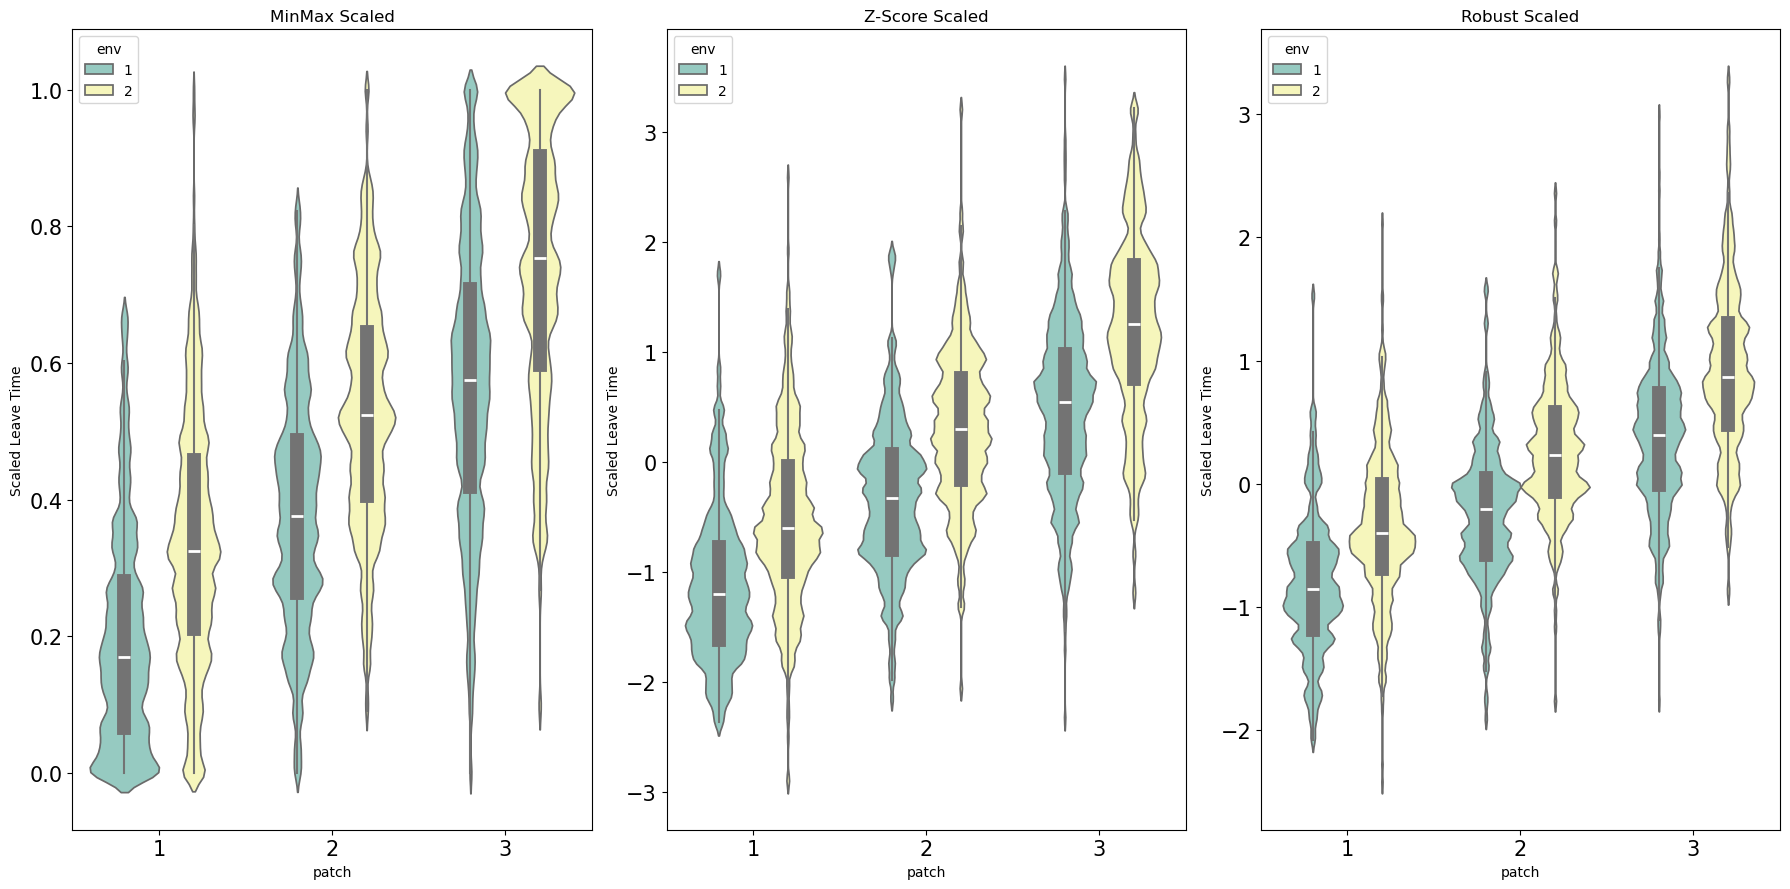

In [82]:
# Create subplots for each scaling method
fig, axes = plt.subplots(1, 3, figsize=(18, 9))

# Plot for each scaling method
scaling_methods = ['leaveT_minmax', 'leaveT_zscore', 'leaveT_robust']
titles = ['MinMax Scaled', 'Z-Score Scaled', 'Robust Scaled']

for ax, method, title in zip(axes, scaling_methods, titles):
    sns.violinplot(x='patch', y=method, data=df_scaled, hue='env', bw_adjust=0.25,
                    inner='box', palette='Set3', ax=ax, inner_kws=dict(box_width=10, whis_width=1.5, color=".45"))
    
    ax.set_title(title)
    ax.set_ylabel('Scaled Leave Time')
    
plt.tight_layout()
plt.show()

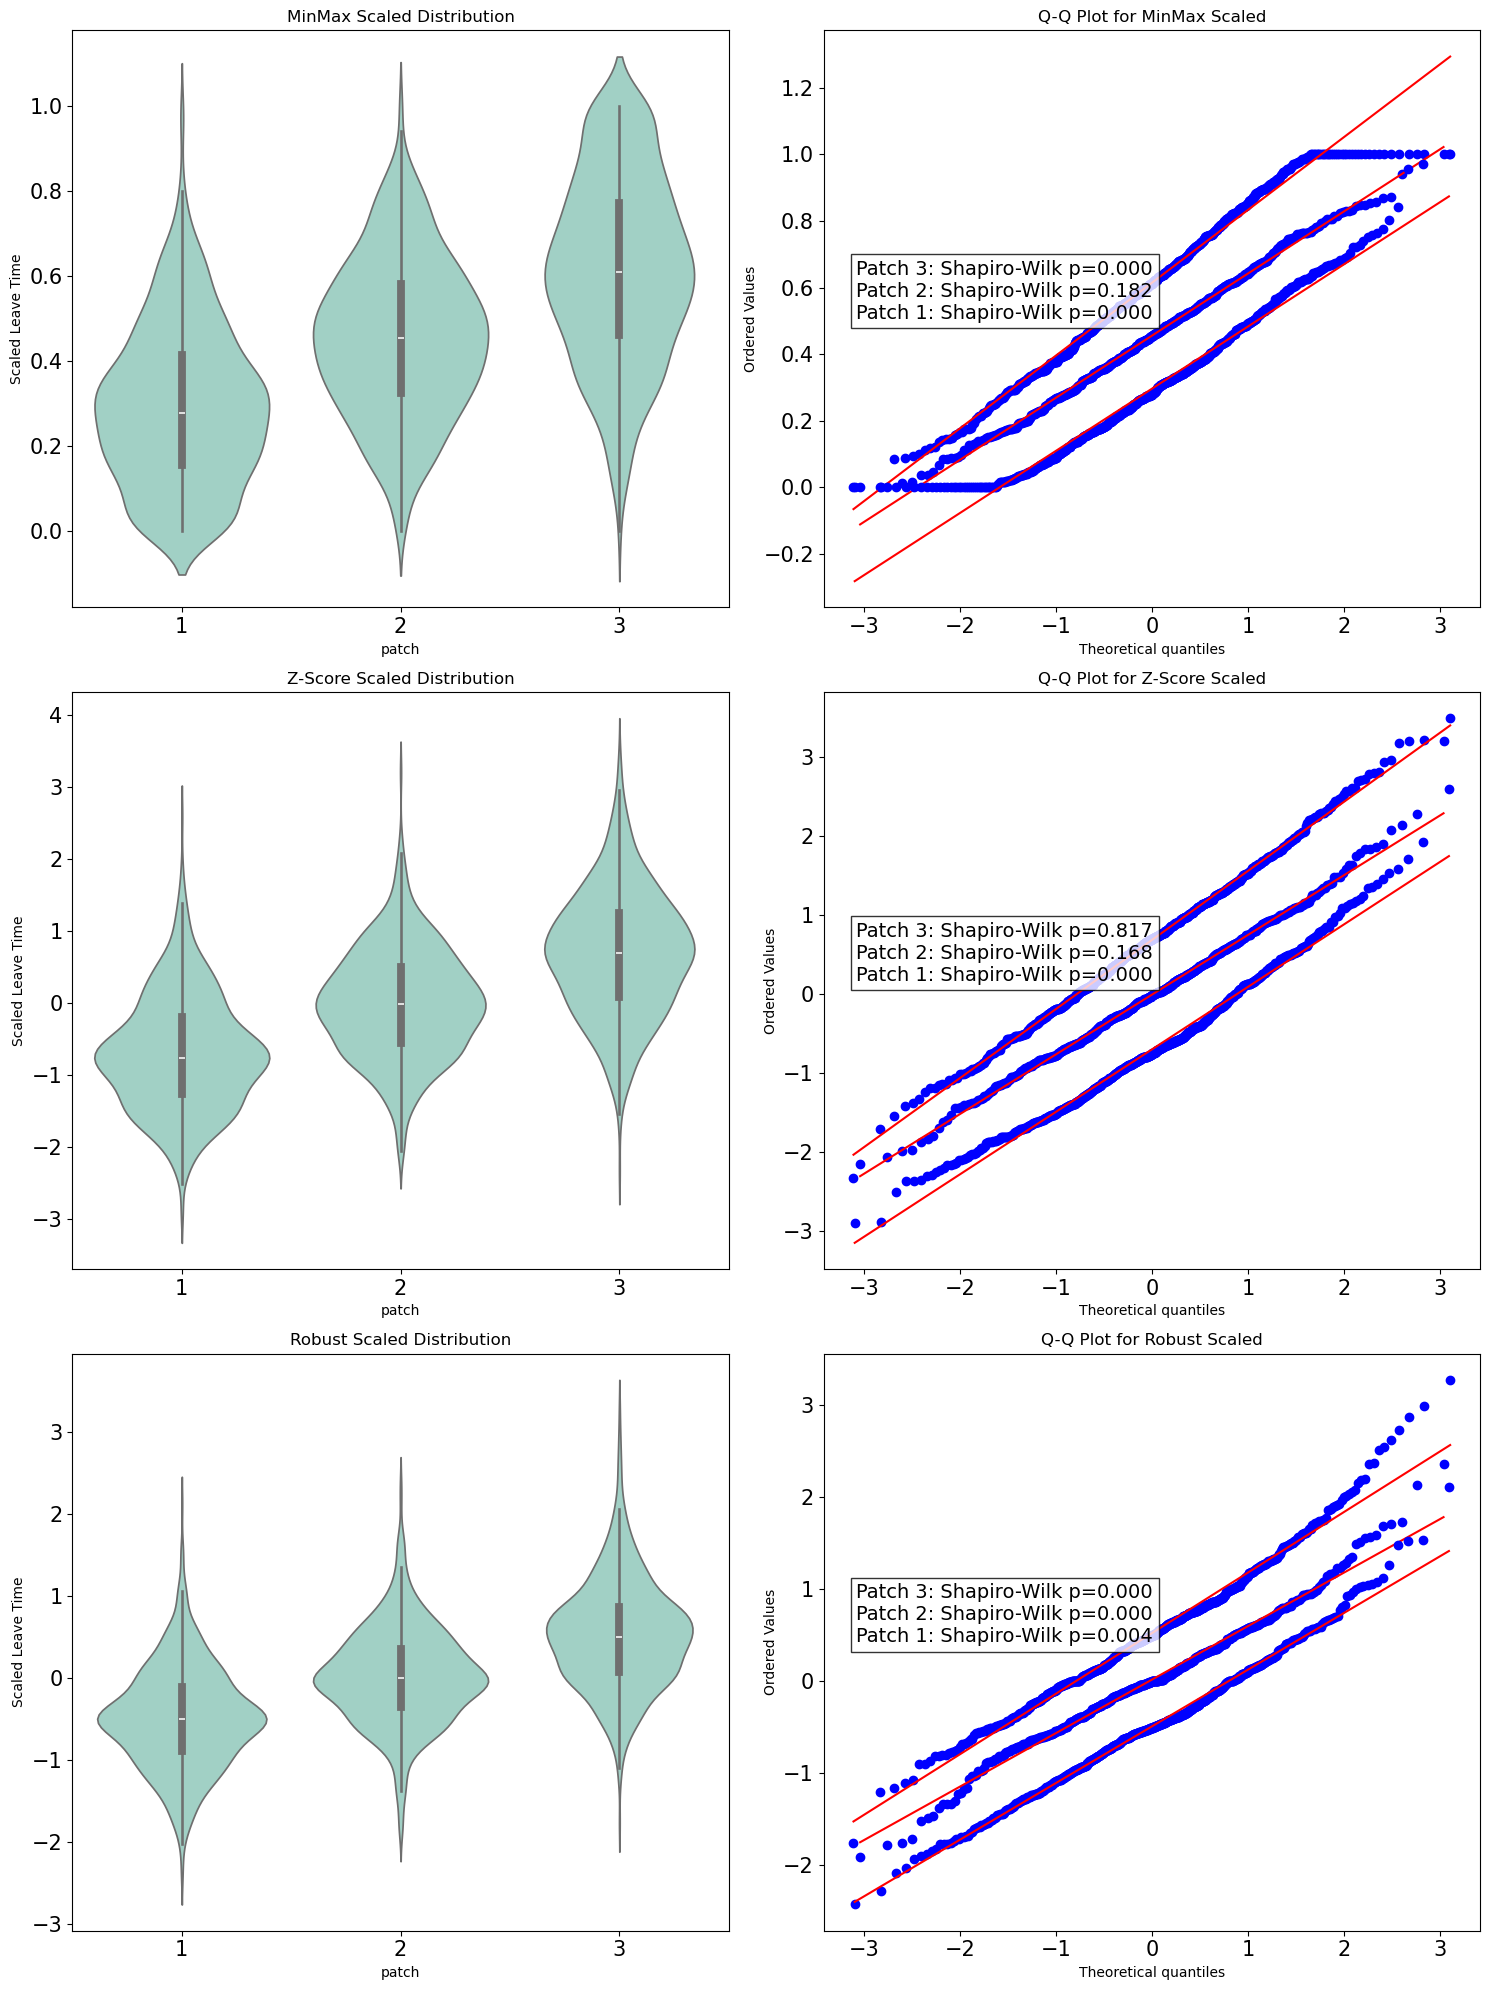


Detailed statistics for leaveT_minmax:

Patch 3:
Skewness: -0.118
Kurtosis: -0.577

Patch 2:
Skewness: 0.090
Kurtosis: -0.351

Patch 1:
Skewness: 0.487
Kurtosis: -0.043

Detailed statistics for leaveT_zscore:

Patch 3:
Skewness: 0.080
Kurtosis: 0.073

Patch 2:
Skewness: 0.188
Kurtosis: 0.390

Patch 1:
Skewness: 0.423
Kurtosis: 0.304

Detailed statistics for leaveT_robust:

Patch 3:
Skewness: 0.417
Kurtosis: 0.917

Patch 2:
Skewness: 0.166
Kurtosis: 1.014

Patch 1:
Skewness: 0.247
Kurtosis: 0.608


In [86]:
# Create figure with subplots (3 rows, 2 columns)
fig, axes = plt.subplots(3, 2, figsize=(15, 20))

# Plot for each scaling method
scaling_methods = ['leaveT_minmax', 'leaveT_zscore', 'leaveT_robust']
titles = ['MinMax Scaled', 'Z-Score Scaled', 'Robust Scaled']

for idx, (method, title) in enumerate(zip(scaling_methods, titles)):
    # Violin plot (first column)
    sns.violinplot(x='patch', y=method, data=df_scaled,
                  inner='box', 
                  color='#99d8c9',
                  ax=axes[idx, 0])
    axes[idx, 0].set_title(f'{title} Distribution')
    axes[idx, 0].set_ylabel('Scaled Leave Time')
    
    # QQ plot and normality tests (second column)
    test_results = []
    for patch in df_scaled['patch'].unique():
        patch_data = df_scaled[df_scaled['patch'] == patch][method]
        
        # Shapiro-Wilk test (best for n < 2000)
        if len(patch_data) < 2000:
            stat, p_value = stats.shapiro(patch_data)
            test_name = 'Shapiro-Wilk'
        else:
            # D'Agostino-Pearson test (better for larger samples)
            stat, p_value = stats.normaltest(patch_data)
            test_name = "D'Agostino-Pearson"
            
        test_results.append(f'Patch {patch}: {test_name} p={p_value:.3f}')
        
        # QQ plot for each patch with different colors
        stats.probplot(patch_data, dist="norm", plot=axes[idx, 1])
    
    axes[idx, 1].set_title(f'Q-Q Plot for {title}')
    
    # Add test results as text
    text_results = '\n'.join(test_results)
    axes[idx, 1].text(.05, 0.5, text_results, 
                     transform=axes[idx, 1].transAxes, 
                     bbox=dict(facecolor='white', alpha=0.8), fontsize=14)

plt.tight_layout()
plt.show()

# Print additional statistics
for method in scaling_methods:
    print(f"\nDetailed statistics for {method}:")
    for patch in df_scaled['patch'].unique():
        patch_data = df_scaled[df_scaled['patch'] == patch][method]
        print(f"\nPatch {patch}:")
        print(f"Skewness: {stats.skew(patch_data):.3f}")
        print(f"Kurtosis: {stats.kurtosis(patch_data):.3f}")